<a href="https://colab.research.google.com/github/nikinuk/Sentiment_Analysis_with_BERT/blob/main/Bert_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Conexao ambiente COLAB (GPU e memóra)

In [ ]:
# Conexão e verificação da GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 27 13:42:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Verificação memória
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Preparação do ambiente

In [ ]:
# Instalação ambiente
!pip install tensorflow_text
!pip install tf-models-official

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Get BERT layer and tokenizer:
MULTI_MODEL = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4'
MULTI_PRE = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparação dos dados para validação

In [ ]:
# Abrir arquivo de treino
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/i2a2/Americanas/train.csv',low_memory=False)
df.shape

(79425, 15)

In [ ]:
# Funções pre-processamento

import re

def cleantexts(text: str) -> str:

    remove_url = re.compile(r'https?://\S+|www\.\S+')
    remove_email = re.compile(r'\S+@\S+')
    remove_extra_space = re.compile(r'\s+')

    # delete digits, special chars, etc.,
    text = re.sub('[^a-zA-Z]', ' ', text)
    # convert to lowercase
    text = text.lower()
    # delete additional spaces, emails and urls
    text = remove_url.sub('', text)
    text = remove_email.sub('', text)
    text = remove_extra_space.sub(' ', text)
    return text

def norm_recom(rec) -> tf.int16: #Mapeia recomendações YesNo para 1 e 0
    if rec == 'Yes':
        return 1
    else:
        return 0

alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Sr|Sra)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Sr|Sra|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def sent_split(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.string)
    return arg

In [ ]:
df['text_list'] = my_func(list(map(sent_split, texto)))

ValueError: ignored

In [ ]:
df = df[['review_title', 'review_text','recommend_to_a_friend', 'rating']].dropna() #guardar os campos e linhas úteis (ver análise dos dados)
texto = 'Titulo: ' + df.review_title.apply(lambda x: str(x)) + ' Revisão: ' + df.review_text.apply(lambda x: str(x))
df['text_list'] = my_func(list(map(sent_split, texto)))
df['clean_text'] = df.review_title.apply(lambda x: cleantexts(x)) + ' ' + df.review_text.apply(lambda x: cleantexts(x)) #Preprocessamento textos
df['rating'] = df['rating'].apply(lambda x: x-1) #Ajustar rating de 0 a 4 para softmax
df['recommend_to_a_friend'] = df['recommend_to_a_friend'].apply(norm_recom) #binarizar recomendação
df.reset_index(inplace=True, drop=True) #Reset índices
df.shape

(77311, 6)

In [ ]:
# Separação em treino e validação mantendo proporção de ratings
train_size = 0.8
train_df,valid_df = train_test_split(df,random_state=42,train_size=train_size,stratify=df.rating.values)
train_df.shape,valid_df.shape

((61848, 6), (15463, 6))

In [ ]:
# Preparação dataframe Tensorflow

batch_size = 64

with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices(((train_df.text_list.values,train_df.recommend_to_a_friend.values), train_df.rating.values)).batch(batch_size)
  valid_data = tf.data.Dataset.from_tensor_slices(((valid_df.text_list.values,valid_df.recommend_to_a_friend.values), valid_df.rating.values)).batch(batch_size)
  all_data = tf.data.Dataset.from_tensor_slices(((df.text_list.values,df.recommend_to_a_friend.values), df.rating.values)).batch(batch_size)

for (text_batch, rec_batch), label_batch in all_data.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    print(f'Recommend: {rec_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

ValueError: ignored

## Testes e verificação do modelo BERT

In [ ]:
bert_preprocess_model = hub.KerasLayer(MULTI_PRE)

In [ ]:
text_test = ['Isso é ótimo. Será mesmo?']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 70646   263   273 65258   119 39759 10661 13544   136   102     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(MULTI_MODEL)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {MULTI_MODEL}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.15552217  0.00060725  0.26228142 -0.14974858 -0.11441837  0.10905613
 -0.02931472  0.32147926 -0.13728954  0.27054378  0.170865   -0.22070691]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.00963905  0.01748935 -0.3144081  ...  0.49013293  0.21220225
   0.06905052]
 [-0.5064307  -0.13173085 -0.3714252  ...  0.73379546  0.17152631
   0.19907095]
 [-0.26477093 -0.26662832 -0.603151   ...  0.6726641   0.43916282
   0.25064102]
 ...
 [ 0.01318061  0.06935434 -0.37639207 ...  0.7516483   0.23205926
   0.19229671]
 [ 0.06318325  0.10074864 -0.03754306 ...  0.49251738  0.409164
  -0.0195887 ]
 [-0.03215151 -0.12457873 -0.10141236 ...  0.46626782  0.33322465
   0.1561204 ]]


## definição do modelo BERT + Decoder

In [ ]:
def create_model():

    #Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(MULTI_PRE, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(MULTI_MODEL, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    out = outputs['pooled_output']

    #Input for recommendations
    rec_input = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='recommendation')

    # Neural network layers
    l1 = tf.keras.layers.Dropout(0.1, name="dropout")(out)
    l2 = tf.keras.layers.Concatenate()([l1,rec_input])
    l3 = tf.keras.layers.Dense(5, activation='softmax', name='output')(l2)

    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input, rec_input], outputs = [l3])

    return model

In [ ]:
with tf.device('/cpu:0'):
  model = create_model()

In [ ]:
from official.nlp import optimization  # para otimizador

epochs = 4 # Dez épocas
steps_per_epoch = tf.data.experimental.cardinality(all_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

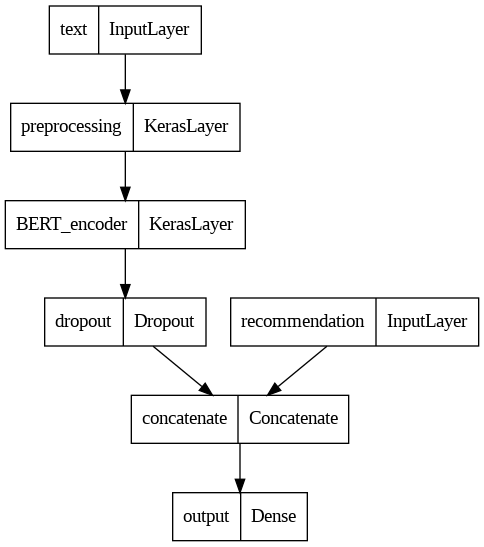

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics='accuracy')

## Treinamento e validação

In [ ]:
# Notas de performance e tempo
# CPU -> ETA: 18h  GPU T4 -> ETA: 1h
# batch = 32 -> RAM GPU = 8.5 / 15
#       = 64 -> RAM GPU = 13.9/ 15

In [ ]:
# Train model

history = model.fit(train_data, validation_data=valid_data, epochs=epochs, verbose=1)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

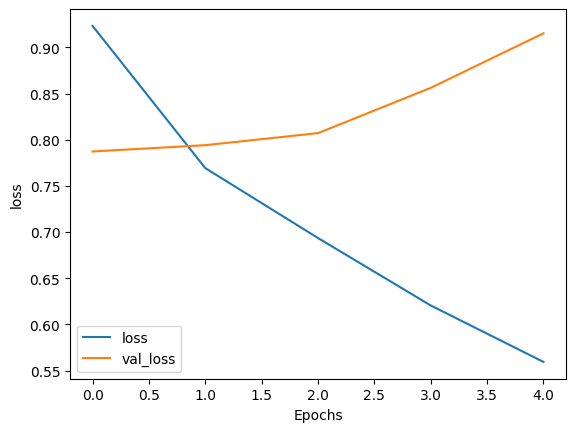

In [ ]:
plot_graphs(history,'loss')

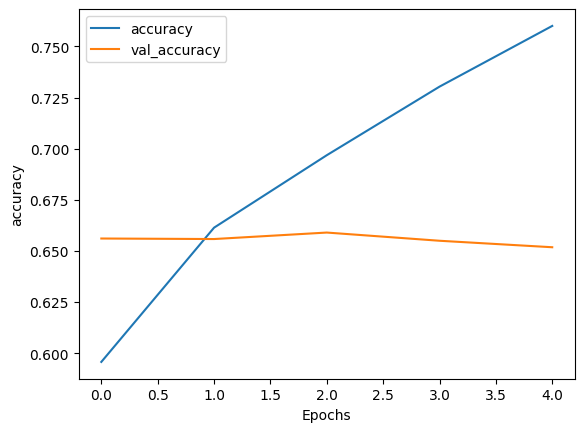

In [ ]:
plot_graphs(history,'accuracy')

## Treinar novamente com todos os dados e parando a cada época para verificar melhor resultado

In [ ]:
with tf.device('/cpu:0'):
  model = create_model()

epochs = 4 # Dez épocas
steps_per_epoch = tf.data.experimental.cardinality(all_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics='accuracy')

In [ ]:
batch_size = 64

del train_data, valid_data
with tf.device('/cpu:0'):
  all_data = tf.data.Dataset.from_tensor_slices(((df.clean_text.values,df.recommend_to_a_friend.values), df.rating.values)).batch(batch_size)

In [ ]:
# Train model

history = model.fit(all_data, epochs=epochs, verbose=1)

1208/1208 [==============================] - 4086s 3s/step - loss: 0.6894 - accuracy: 0.6993


In [ ]:
model.save('/content/drive/MyDrive/i2a2/Americanas/bert_model_full_4ep.keras')

In [ ]:
# Tratamento da base de teste

dftest = pd.read_csv('/content/drive/MyDrive/i2a2/Americanas/test.csv', low_memory=False, parse_dates=[1])
dftest['clean_text'] = dftest.review_title.apply(lambda x: cleantexts(str(x))) + ' ' + dftest.review_text.apply(lambda x: cleantexts(str(x)))
dftest['recommend_to_a_friend'] = dftest['recommend_to_a_friend'].apply(norm_recom)

reviews = list(dftest.clean_text.values)
recommends = list(dftest.recommend_to_a_friend.values)



In [ ]:
del all_data
with tf.device('/cpu:0'):
  test_data = tf.data.Dataset.from_tensor_slices({'text': dftest.clean_text.values, 'recommendation': dftest.recommend_to_a_friend.values}).batch(batch_size)

In [ ]:
#Previsão
predictions = model.predict(test_data, verbose=1)

828/828 [==============================] - 655s 790ms/step


In [ ]:
#Transformar previsão 'softmax' em ratings
pred=[]
for p in predictions:
    pred.append(np.argmax(p)+1)
dftest['rating']=pred

#Salvar arquivoi de submissão
dftest[['ID','rating']].to_csv('/content/drive/MyDrive/i2a2/Americanas/submission_6.csv', index=False)